# SocialStock Data Analysis

This notebook has the following objectives:

1) find equilibrium time in IncDistr vs time plot <br>
2) visualize the social network each day of the simulation <br>
3) show histogram about opinion sum and companies' indexes <br>
4) find equilibrium time in opinions vs time plot

In [49]:
# SETTING THE PARAMETERS
companies=2
op_range=5
users=100
gamma = 2.5



In [50]:
# IMPORTING LIBRARIES
import networkx as nx
import pandas as pd

import numpy as np
#from matplotlib import pyplot as plt

import seaborn as sns
sns.set()

In [51]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## 1) Equilibrium time in IncDistr vs time plot 

In [52]:
from pathlib import Path
d = Path().resolve().parent 
print(str(d))


/home/federico/git/JadeProjects/SocialStock


In [61]:
# IMPORTING DATASET FOR 1) AND 2)
from pathlib import Path
d = Path().resolve().parent 
data = str(d) + "/data/c"+str(companies)+"r"+str(op_range)+"n"+str(users)
print(data)
file = open( data + "Int.txt")

tit = file.readline()

X = []
nn = {}

for l in file.readlines() :
    line = l.split(":")
    
    line[0:4] = [int(i) for i in line[0:4]]
    line[4] = line[4][1:-2].split(", ")
    
    ############DELAING WITH 0-DEGREE USERS#####
    if line[4][0] == "" :
        line[4] = []
    else : 
        line[4] = [int(i) for i in line[4]]
    ############################################

    X.append(line[0:4])
    nn[ (line[0],line[1]) ] = line[4]

X = np.array(X)
X = pd.DataFrame(X) 

tit = tit.split("-")[:-1]
X.columns = tit
X.sort_values(["uDays" , "ind"])

X1 = X[X.uDays==1]

uDays = int(X.shape[0]/users)
Deg = np.array(X1.sort_values("ind").deg)

##nearest_neighbours[4]

#dizionario dei nearest neighbours nel quarto giorno
#si hanno tante key-value pairs quante gli user

# key : indice dello user
# value : lista con gli indici della callout list 
nearest_neighbours = {}

for d in range(uDays) :
    nearest_neighbours[d+1] = {}
    for u in range(users) :
        nearest_neighbours[d+1][u] = nn[(d+1,u)]

/home/federico/git/JadeProjects/SocialStock/data/c2r5n100
12




77




68




38




3




99




66




66




56




4




14




89




14




61









29




0




45




43




44




41




35




17




18




33




57




86




66




16




56




74




25




65




75




66




7




72




77




44




6




62




61




56




77




29




24




92




39




71




51




64




31




20




75




36




97




13




8




24




24




83




86




71




15




3




57




44




34




79




66




8




69




88




34




55




15




64




62




99




78




81




53




46




3




73




45




65




1




23




0




67




61




83




66




40




35




79




66




66




90




27




29




58




66




75




26









23




39




41




19




98




95




2




9




26




36




15




89




36




94




32




53




76




28




7




79




83




76




17




30




24




57




43




92




10




71




3

KeyError: (8, 25)

In [48]:
IncDistr = []
for d in range(uDays):
    IncDistr.append(np.unique(X[X.uDays==d+1].incl, return_counts= True)[1])
IncDistr = np.array(IncDistr)

plt.figure(figsize=(10,7))
plt.scatter(y=IncDistr[:,0] , x=range(uDays) , color = "red" )
plt.scatter(y=IncDistr[:,1] , x=range(uDays) , color = "green")
plt.scatter(y=IncDistr[:,2] , x=range(uDays) , color = "blue")

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('$time$', fontsize=17)
plt.ylabel('$IncDistr$', fontsize=17)

AttributeError: 'list' object has no attribute 'uDays'

In [40]:
t=0
IncDistr_t=[]
for i in IncDistr:
    if( np.array_equal(i,IncDistr_t) ):
        print('Equilibrium time is '+ str(t))
        break
    else: 
        IncDistr_t=[j for j in i]
        t+=1

In [41]:
# OPINION MATRIX

file = open( data + ".txt")
tit = file.readline()

Op = []

for l in file.readlines() :
    line = (l.split(","))
    line[companies-1] = line[companies-1][:-2]
    line = [float(i) for i in line]
    Op.append(line)
    
# O is a dictionary with: (key : day) (value : opinion matrix of that day)    
O = {}
index = 0
for d in range(uDays) :
    O[d+1] = np.array(Op[index:(index + users)])
    index = index + users

## 2) Visualize Network of Day 1

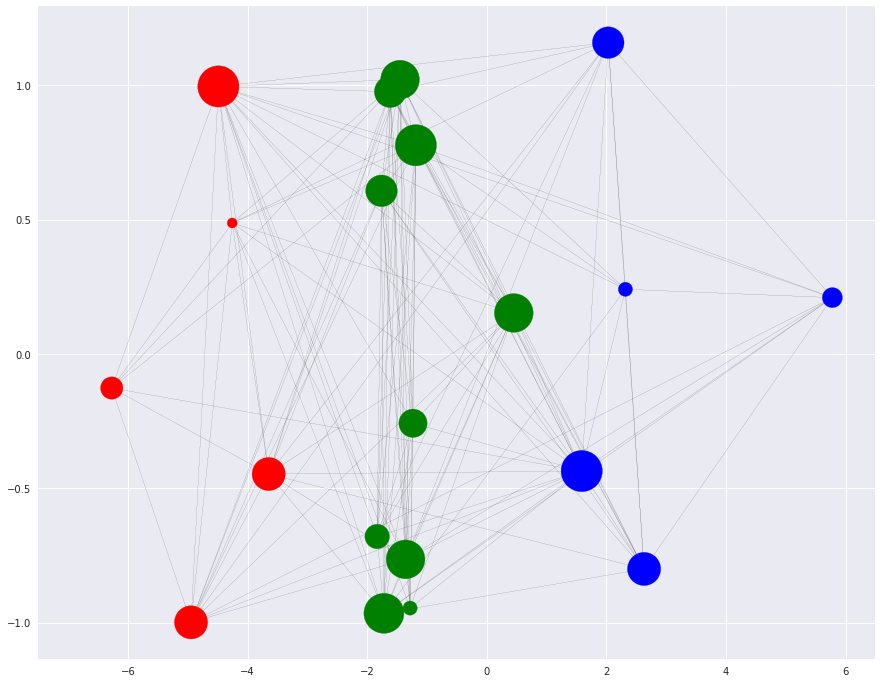

In [42]:
def Graphday(X , day) :
    G1 = nx.Graph()
    X1 = X[X.uDays == day]
    X1 = X1.sort_values(["ind"])

    for u in range(users) : 
            for n in nearest_neighbours[day][u] :
                G1.add_edge(u,n)

    pos1 = nx.circular_layout(G1)
    incols = np.array(["red","green","blue"])

    m = np.sum(O[day] , axis =1)
    for i in range(users) :
        pos1[i][0] = m[i] + np.random.normal(scale =0.2)
        pos1[i][1] += np.random.normal(scale =0.2)

    plt.figure(1,figsize=(15,12)) 
    plt.xlim( (np.min(m) -1 , np.max(m) +1) )
    nx.draw_networkx(G1,
                     node_size= X1.deg*100, 
                     pos = pos1,
                     node_color= incols[np.array(X1.incl +1)], 
                     with_labels=False,
                     width=0.1)
    
    
Graphday(X,4)
plt.show()

In [ ]:
# DEGREE DISTRIBUTION
plt.hist(X1.deg, range=(0,20))
plt.show()

## 4) Equilibrium time in sum(opinions) vs time plot 

In [ ]:
# defining dictiorary time: sum of opinions at that time
O_t={}
for i in O.keys():
    # list of vector to sum
    vec_list=[O[i][j] for j in range(users)]
    # summing vectors
    O_t[i] = np.sum( vec_list, axis=0 )
O_t

In [ ]:
plt.figure(figsize=(10,7))
for i in range(companies):
    Y_comp=[O_t[j+1][i] for j in range(uDays)]
    plt.scatter( y=Y_comp , x=range(uDays) )

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('$time$', fontsize=17)
plt.ylabel('$Opinions$', fontsize=17)

In [ ]:
t=0
for i in range(len(Y_comp)):
    #print(Y_comp[i])
    if( np.array_equal(Y_comp[i],Y_comp[i+6])):
        print('Equilibrium time is '+ str(t))
        break
    else: 
        t+=1

##### 3) Histrogram opinions - companies

In [ ]:
# CHOOSE DAY
day=1
plt.figure(figsize=(10,7))

colors=[]
for i in O_t[day]:
    if(i<0): colors.append('red')
    if(i>0): colors.append('blue')
        
# histogram
bar([i for i in range(companies)], list(O_t[day]), color=np.array(colors))

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('$Cumulative-Opinion$', fontsize=17)
plt.xlabel('$Company-index$', fontsize=17)

In [33]:
feX = pd.Series( [np.array([1,2,3]) , np.array([4,6]), np.array([4,6,4])])
feX.name = "arrays"
feX

0    [1, 2, 3]
1       [4, 6]
2    [4, 6, 4]
Name: arrays, dtype: object